# Sinus Function Approximation Experiment

This notebook trains a neural network to approximate a sine function 
under noise in both inputs and outputs. The code is refactored for clarity 
and easy configurability. You can change hyperparameters such as:
- Number of hidden layers
- Hidden layer width
- Learning rate
- Number of epochs
- Amount of noise in the inputs and outputs
- Data generation methods (linspace vs. random)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

## Hyperparameters & Configuration

In [2]:
# Data parameters
TOTAL_SIZE = 200         # total number of data points
VAL_RATIO = 0.3          # fraction of data for validation
X_INTERVAL = 2           # multiplier for the range of x: [-2π, 2π]
HOW_TO_GENERATE = "linspace"  # or "random"

# Noise parameters
INPUT_NOISE_STD = 0.2    # standard deviation of noise added to x
OUTPUT_NOISE_STD = 0.1   # standard deviation of noise added to sin(x)

# Model architecture
NUM_INPUTS = 1           # we feed x only (or could feed x + noise as 2D input if you wish)
HIDDEN_LAYERS = 2        # how many hidden layers
HIDDEN_DIM = 32          # width of each hidden layer
ACTIVATION = nn.ReLU()   # activation function
NUM_OUTPUTS = 1

# Training parameters
NUM_EPOCHS = 2000
LEARNING_RATE = 1e-3
BATCH_SIZE = 32

# Whether or not to use GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cpu


## Data Generation

In [3]:
def generate_sin_data(
    total_size: int,
    val_ratio: float,
    x_interval: float,
    how: str = "linspace",
    input_noise_std: float = 0.0,
    output_noise_std: float = 0.0
):
    """
    Generates (x, sin(x)) data, splits it into training and validation sets.
    Optionally adds noise to inputs and outputs.

    Args:
        total_size (int): total number of data points.
        val_ratio (float): fraction of data used for validation.
        x_interval (float): the interval multiplier for x in [-x_interval*π, x_interval*π].
        how (str): "linspace" or "random"; method of generating x.
        input_noise_std (float): standard deviation for noise added to x.
        output_noise_std (float): standard deviation for noise added to sin(x).

    Returns:
        (X_train, y_train, X_val, y_val):
            X_train: (N_train, 1) torch.Tensor
            y_train: (N_train,)   torch.Tensor
            X_val:   (N_val, 1)   torch.Tensor
            y_val:   (N_val,)     torch.Tensor
    """
    # Generate x
    if how.lower() == "linspace":
        x = np.linspace(-x_interval * np.pi, x_interval * np.pi, total_size)
    elif how.lower() == "random":
        x = np.random.uniform(-x_interval * np.pi, x_interval * np.pi, size=total_size)
    else:
        raise ValueError("Invalid generation method. Choose 'linspace' or 'random'.")

    # Add optional noise to x
    x_noisy = x + np.random.normal(loc=0.0, scale=input_noise_std, size=total_size)

    # Generate output sin(x) with optional noise
    y = np.sin(x_noisy) + np.random.normal(loc=0.0, scale=output_noise_std, size=total_size)

    # Convert to torch Tensors
    X = torch.tensor(x_noisy, dtype=torch.float32).view(-1, 1)
    Y = torch.tensor(y, dtype=torch.float32)

    # Create dataset
    dataset = torch.utils.data.TensorDataset(X, Y)

    # Split into train/val
    val_size = int(val_ratio * total_size)
    train_size = total_size - val_size

    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )

    # Extract X_train, y_train, X_val, y_val
    X_train, y_train = train_dataset[:]
    X_val,   y_val   = val_dataset[:]

    return X_train, y_train, X_val, y_val

## Model Definition

In [4]:
class SinApproximator(nn.Module):
    """
    A simple feedforward neural network for approximating sin(x).
    """
    def __init__(self, 
                 num_inputs: int = 1, 
                 hidden_layers: int = 2, 
                 hidden_dim: int = 32, 
                 num_outputs: int = 1,
                 activation: nn.Module = nn.ReLU()):
        super(SinApproximator, self).__init__()

        layers = []
        # Input layer
        layers.append(nn.Linear(num_inputs, hidden_dim))
        layers.append(activation)

        # Hidden layers
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation)

        # Output layer
        layers.append(nn.Linear(hidden_dim, num_outputs))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

## Training Loop

In [5]:
def train_model(
    model: nn.Module,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    num_epochs: int,
    batch_size: int,
    lr: float,
    device: str = "cpu"
):
    """
    Trains the model on (X_train, y_train), validates on (X_val, y_val).

    Args:
        model (nn.Module): PyTorch model to train.
        X_train (torch.Tensor): training inputs.
        y_train (torch.Tensor): training targets.
        X_val (torch.Tensor): validation inputs.
        y_val (torch.Tensor): validation targets.
        num_epochs (int): number of training epochs.
        batch_size (int): mini-batch size.
        lr (float): learning rate.
        device (str): "cpu" or "cuda"

    Returns:
        (train_losses, val_losses, best_model_state):
            train_losses: list of training MSE values over epochs
            val_losses: list of validation MSE values over epochs
            best_model_state: a copy of the best model state_dict (lowest val loss)
    """
    # Move model & data to the device (cpu or gpu)
    model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val   = X_val.to(device)
    y_val   = y_val.to(device)

    # Create data loaders
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    best_val_loss = float("inf")
    best_model_state = None

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            preds = model(batch_X)
            loss = criterion(preds.squeeze(), batch_y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * batch_X.size(0)

        # Average training loss over all batches
        epoch_train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val).squeeze()
            val_loss = criterion(val_preds, y_val).item()

        train_losses.append(epoch_train_loss)
        val_losses.append(val_loss)

        # Track the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = {k: v.cpu() for k, v in model.state_dict().items()}

        # Optionally print progress
        if (epoch + 1) % 500 == 0:
            print(f"[Epoch {epoch+1}/{num_epochs}] "
                  f"Train Loss: {epoch_train_loss:.6f} | Val Loss: {val_loss:.6f}")

    return train_losses, val_losses, best_model_state

## Running the Experiment
1) Generate data

In [6]:
X_train, y_train, X_val, y_val = generate_sin_data(
    total_size=TOTAL_SIZE,
    val_ratio=VAL_RATIO,
    x_interval=X_INTERVAL,
    how=HOW_TO_GENERATE,
    input_noise_std=INPUT_NOISE_STD,
    output_noise_std=OUTPUT_NOISE_STD
)

2) Create the model

In [7]:
model = SinApproximator(
    num_inputs=NUM_INPUTS,
    hidden_layers=HIDDEN_LAYERS,
    hidden_dim=HIDDEN_DIM,
    num_outputs=NUM_OUTPUTS,
    activation=ACTIVATION
)

3) Train the model

In [8]:
train_losses, val_losses, best_state = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    device=DEVICE
)

[Epoch 500/2000] Train Loss: 0.018301 | Val Loss: 0.024926
[Epoch 1000/2000] Train Loss: 0.010347 | Val Loss: 0.013484
[Epoch 1500/2000] Train Loss: 0.012949 | Val Loss: 0.012059
[Epoch 2000/2000] Train Loss: 0.009430 | Val Loss: 0.012407


## Evaluation & Plots

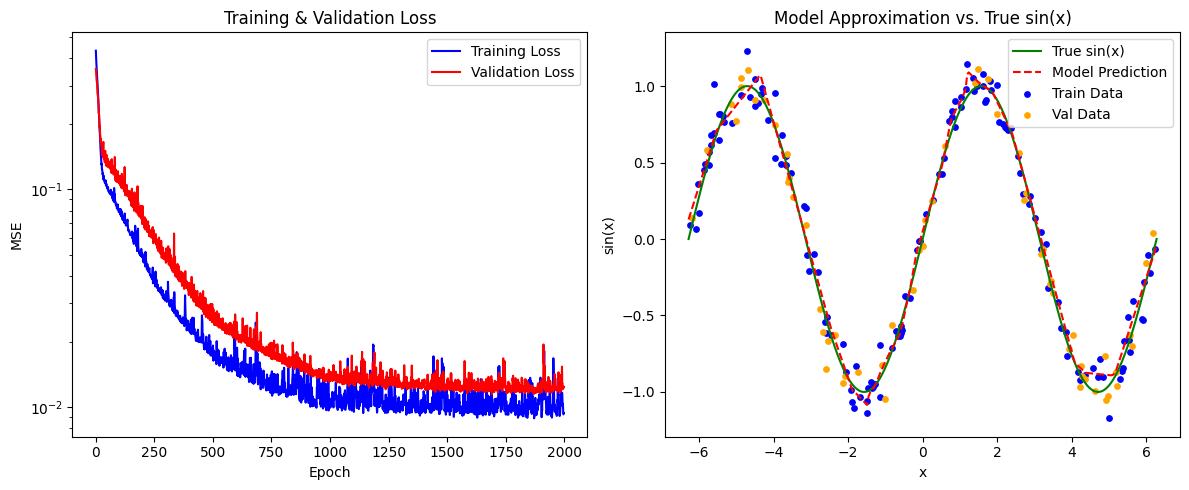

In [9]:
model.load_state_dict(best_state)
def plot_results(
    model: nn.Module,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    train_losses: list,
    val_losses: list,
    device: str = "cpu"
):
    """
    Makes plots of:
      - Predicted vs. true sin(x) for a dense range of x
      - Training vs. Validation losses (MSE) over epochs
      - Training vs. Validation points

    Args:
        model (nn.Module): trained model
        X_train (torch.Tensor): training inputs
        y_train (torch.Tensor): training targets
        X_val (torch.Tensor): validation inputs
        y_val (torch.Tensor): validation targets
        train_losses (list): training MSE over epochs
        val_losses (list): validation MSE over epochs
        device (str): "cpu" or "cuda"
    """
    model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val   = X_val.to(device)
    y_val   = y_val.to(device)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # 1) Plot training & validation losses
    axs[0].plot(train_losses, label="Training Loss", color="blue")
    axs[0].plot(val_losses, label="Validation Loss", color="red")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("MSE")
    axs[0].set_title("Training & Validation Loss")
    axs[0].legend()
    axs[0].set_yscale("log")  # optional

    # 2) Plot predictions vs. ground truth
    #    We'll create a dense array of x for smooth plotting
    x_plot = np.linspace(-X_INTERVAL * np.pi, X_INTERVAL * np.pi, 300)
    x_plot_t = torch.tensor(x_plot, dtype=torch.float32).view(-1, 1).to(device)

    model.eval()
    with torch.no_grad():
        preds_plot = model(x_plot_t).squeeze().cpu().numpy()

    # True sine
    sine_plot = np.sin(x_plot)

    # Plot them
    axs[1].plot(x_plot, sine_plot, label="True sin(x)", color="green")
    axs[1].plot(x_plot, preds_plot, label="Model Prediction", color="red", linestyle="--")

    # Also show the training and validation data points
    axs[1].scatter(X_train.cpu().numpy(), y_train.cpu().numpy(), label="Train Data", color="blue", s=15)
    axs[1].scatter(X_val.cpu().numpy(),   y_val.cpu().numpy(),   label="Val Data",   color="orange", s=15)

    axs[1].set_xlabel("x")
    axs[1].set_ylabel("sin(x)")
    axs[1].set_title("Model Approximation vs. True sin(x)")
    axs[1].legend()

    plt.tight_layout()
    plt.show()


plot_results(
    model,
    X_train, 
    y_train, 
    X_val, 
    y_val, 
    train_losses, 
    val_losses,
    device=DEVICE
)